## Project - 01

Contributors: Pratyush Sudhakar (ps2245), Aditya Syam (as2839), Cedric Orton-Urbina (ceo29)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import sys
import os
import re
import time
import math

### Column Pivoting QR Factorization (Goals 1-3)

For this part, we will implement a $QR$ Factorization of a given matrix $A$ with complete pivoting.

**Strategy**: We implement the QR Factorization with complete pivoting as proposed by Businger & Golub (1965), using the strategy to store the squared 2-norms of columns of the matrix $A$ in array $S$, and in each iteration ($k$), update the array entries by subtracting the squares of the top row.

$$
S_j^{(k+1)} = S_j^{(k)} - (a_{k, j}^{(k+1)})^2, \quad j = k, k+1, \ldots, n
$$

In [134]:
# function to compute and return the 2-norm of all column vectors of A
def compute_norms(A):
    return np.linalg.norm(A, axis=0)


# algorithm to compute the QR factorization of A using Householder reflections and Column pivoting
def compute_QR(A, k, P=None, Q=None):
    m, n = A.shape
    column_norms = compute_norms(A)
    R = np.copy(A)

    for j in range(k):
        # Find the column with the maximum norm
        max_norm_col_index = np.argmax(column_norms[j:]) + j
        # Swap columns if necessary
        if max_norm_col_index != j:
            R[:, [j, max_norm_col_index]] = R[:, [max_norm_col_index, j]]
            column_norms[j], column_norms[max_norm_col_index] = (
                column_norms[max_norm_col_index],
                column_norms[j],
            )
            
            P[:, [j, max_norm_col_index]] = P[:, [max_norm_col_index, j]]

        # Select column vector for transformation
        w = R[j:, j]
        s = -np.sign(w[0])
        u = s * np.linalg.norm(w) * np.eye(len(w), 1)[:, 0] - w

        # Compute Householder reflection
        u /= np.linalg.norm(u)
        R[j:, j:] -= 2 * np.outer(u, u).dot(R[j:, j:])
        R[j + 1 : m, j] = 0

        # Update Q
        Q[:, j:] -= 2 * Q[:, j:].dot(np.outer(u, u))  # Complexity: O(mn)

        # Update the norms of the remaining columns
        if j < n - 1:  # Prevent out of bounds when j is the last column
            norm_updates = np.sqrt(column_norms[j + 1 : n] ** 2 - R[j, j + 1 : n] ** 2)
            column_norms[j + 1 : n] = norm_updates

    return Q, R, P


# run the QR factorization algorithm and plot the time taken for different matrix sizes
def plot_QR_time():
    m_values = range(1000, 4000, 500)
    n_values = range(1000, 4000, 500)
    k = 20
    times = np.zeros((len(m_values), len(n_values)))

    for m in m_values:
        for n in n_values:
            A = np.random.rand(m, n)
            Q = np.eye(m)
            P = np.eye(n)
            start = time.time_ns()
            compute_QR(A, k, P, Q)
            end = time.time_ns()
            print(f"m = {m}, n = {n}, time = {end - start} ns")
            times[m_values.index(m), n_values.index(n)] = end - start

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        if i == 0:
            x = n_values
            y = times[0, :]
            ax[i].set_title("n varies, m = 1000")
            ax[i].set_xlabel("n")
            ax[i].set_ylabel("Time (ns)")
        elif i == 1:
            x = m_values
            y = times[:, 0]
            ax[i].set_title("m varies, n = 1000")
            ax[i].set_xlabel("m")
            ax[i].set_ylabel("Time (ns)")
        else:
            x = m_values
            y = times.diagonal()
            ax[i].set_title("m = n varies")
            ax[i].set_xlabel("m = n")
            ax[i].set_ylabel("Time (ns)")

        ax[i].plot(x, y, "o")
        slope, intercept = np.polyfit(np.log(x), np.log(y), 1)
        ax[i].plot(x, np.exp(intercept) * x**slope, label=f"Slope: {slope:.2f}")
        ax[i].legend()

    plt.show()


# plot_QR_time()
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=float)
Q, R, P = compute_QR(A, 3, np.eye(3), np.eye(3))

print(Q @ R @ P.T)
print(A)
print(np.linalg.norm(Q @ R @ P.T - A))

[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
5.004631229248277e-15


C:\Users\praty\AppData\Local\Temp/ipykernel_12004/2615224602.py:40: RuntimeWarning: invalid value encountered in sqrt
  norm_updates = np.sqrt(column_norms[j + 1 : n] ** 2 - R[j, j + 1 : n] ** 2)


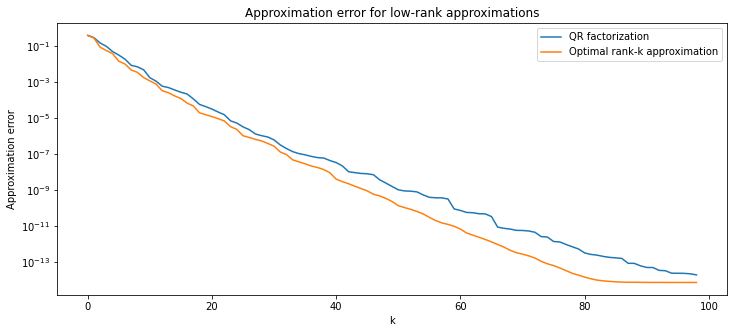

In [135]:
def generate_matrix_G(n):
    points = np.random.uniform(0, 1, (n, 2))
    G = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            G[i, j] = np.exp(-2 * np.linalg.norm(points[i] - points[j]) ** 2)
    return G


def approximation_error(G, A_k):
    return np.linalg.norm(G - A_k, ord="fro") / np.linalg.norm(G, ord="fro")

def low_rank_approximations(G, k_max=100):
    QR_errors = []
    Optimal_errors = []
    A = G[:, :]

    # svd
    U, S, V = np.linalg.svd(G)

    for k in range(1, k_max):
        # QR factorization
        Q, R, P = compute_QR(A, k, np.eye(A.shape[1]), np.eye(A.shape[0]))
        A_k = Q[:, :k] @ R[:k, :] @ P.T
        QR_errors.append(approximation_error(G, A_k))

        # Optimal rank-k approximation
        A_k_optimal = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
        Optimal_errors.append(approximation_error(G, A_k_optimal))

    return QR_errors, Optimal_errors

# Generate the matrix G
n = 200
G = generate_matrix_G(n)

# Compute the low-rank approximations
QR_errors, Optimal_errors = low_rank_approximations(G)

# Plot the errors
plt.figure(figsize=(12, 5))
# logaritmic scale
plt.yscale("log")
plt.plot(QR_errors, label="QR factorization")
plt.plot(Optimal_errors, label="Optimal rank-k approximation")
plt.title("Approximation error for low-rank approximations")
plt.xlabel("k")
plt.ylabel("Approximation error")
plt.legend()
plt.show()

### Compressing a Simple Neural Network

**Step 1**: Use a prebuilt $qr$ to compute the $q_k$, $r_k$ as mentioned at the end of the report.<br>
**Step 2**: Implement the helper functions (softmax, ReLu, etc...).<br>
**Step 3**: Implement the model in $eq^n(10)$ - at this point we are given the $W$ matrices, hence no need to compute them just yet.<br>
**Step 4**: Implement SVD QR Factorization, then compare 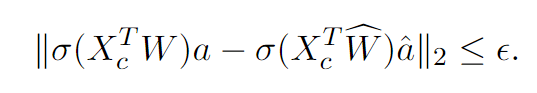 where the term is the matrix that we are asked to compute.<br>
**Step 5**: Vary $\epsilon$ so less columns are selected ($k$ decreases with decrease in $\epsilon$).<br>

In [115]:
def relu(x):
    return np.maximum(x, 0)


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def layer(x, W):
    return relu(np.dot(x.T, W))

def model(x, Ws):
    for W in Ws[:-1]:
        x = layer(x, W)
    x = softmax(np.dot(Ws[-1].T, x))
    return x


def compute_accuracy(X_test, y_test, Ws):
    y_pred = np.argmax(np.array([model(x, Ws) for x in X_test.T]), axis=1)
    return np.mean(y_pred == y_test)


# load Ws, XC, XT, and y from .txt files where each row is a vector and columns are separated by commas
# Ws = np.loadtxt("Ws.txt", delimiter=",")
XC = np.loadtxt("data/XC.txt", delimiter=",")
XT = np.loadtxt("data/XT.txt", delimiter=",")
y = np.loadtxt("data/y.txt", delimiter=",")
Ws = []
for i in range(1, 8):
    Ws.append(np.loadtxt(f"data/W{i}.txt", delimiter=","))
Ws.append(np.loadtxt(f"data/WS.txt", delimiter=","))

# Compute the accuracy of the model
accuracy = compute_accuracy(XT, y, Ws)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.70


In [136]:
# Compute the low-rank approximations of the matrix layer(XC, Ws[0]) using QR factorization with column pivoting and show how the error compares with that of SVD

# first, use column pivoting QR factorization to select the best k
A = layer(XC, Ws[0])
print(A.shape)
QR_errors, Optimal_errors = low_rank_approximations(A, k_max=A.shape[0])

# Plot the errors
plt.figure(figsize=(12, 5))
# logaritmic scale
plt.yscale("log")
plt.plot(QR_errors, label="QR factorization")
plt.plot(Optimal_errors, label="Optimal rank-k approximation")
plt.title("Approximation error for low-rank approximations")
plt.xlabel("k")
plt.ylabel("Approximation error")
plt.legend()
plt.show()

(1024, 2048)


In [ ]:
"""Goal 6: Use the scheme outlined above to compress the first layer of the provided model,
i.e., we want to reduce the number of columns in W (1), and show how the accuracy varies as
the size of the model is reduced (i.e., start with some small enough  such that no neurons are
removed and then gradually increase  to get smaller and smaller models until the accuracy
degrades significantly). Your results/discussion should include a plot of the accuracy vs the
fraction of columns W (1) that remain
"""

def compress_layer(X, W, epsilon):
    # Compute the low-rank approximations of the matrix layer(X, W) using QR factorization with column pivoting
    A = layer(X, W)
    QR_errors, _ = low_rank_approximations(A, k_max=A.shape[0])
    k = np.argmax(np.array(QR_errors) < epsilon) + 1
    return W[:, :k]

def plot_accuracy_vs_fraction(XC, XT, y, Ws, epsilon_values):
    accuracies = []
    for epsilon in epsilon_values:
        Ws_compressed = [compress_layer(XC, W, epsilon) for W in Ws]
        accuracy = compute_accuracy(XT, y, Ws_compressed)
        accuracies.append(accuracy)

    plt.figure(figsize=(12, 5))
    plt.plot(epsilon_values, accuracies)
    plt.title("Accuracy vs the fraction of columns W(1) that remain")
    plt.xlabel("Fraction of columns W(1) that remain")
    plt.ylabel("Accuracy")
    plt.show()

epsilon_values = np.linspace(0.1, 0.9, 10)
plot_accuracy_vs_fraction(XC, XT, y, Ws, epsilon_values)

In [ ]:
"""Goal 7: Compress the whole model for a few  you choose based on your answer to the
prior goal (e.g., picking points that seem like a reasonable trade off between model size and
accuracy). Again, report the accuracy of your compressed model vs the fraction of total
number of columns in̂ W (1) througĥ W (7) that remain. What do you observe? Comment on
your results and why (or why not) you feel the scheme implemented is practical/useful.
"""

def compress_model(XC, XT, y, Ws, epsilon):
    Ws_compressed = [compress_layer(XC, W, epsilon) for W in Ws]
    accuracy = compute_accuracy(XT, y, Ws_compressed)
    return accuracy

epsilon_values = np.linspace(0.1, 0.9, 10)
accuracies = [compress_model(XC, XT, y, Ws, epsilon) for epsilon in epsilon_values]

plt.figure(figsize=(12, 5))
plt.plot(epsilon_values, accuracies)
plt.title("Accuracy vs the fraction of total number of columns in W(1) through W(7) that remain")
plt.xlabel("Fraction of total number of columns in W(1) through W(7) that remain")
plt.ylabel("Accuracy")
plt.show()